# Data loader

In [0]:
from torchvision import datasets
import gzip
import os
import pickle
import urllib

import random
import numpy as np
import torch
import torch.utils.data as data
from torchvision import transforms

# Reproducibility
reproduce = True
if reproduce:
    FIXED_SEED = 5
    random.seed(FIXED_SEED)
    torch.manual_seed(FIXED_SEED)
    torch.cuda.manual_seed(FIXED_SEED)
    np.random.seed(FIXED_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_loader(config):
    svhn_transform = transforms.Compose([
        transforms.Resize(config.image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    mnist_transform = transforms.Compose([
        transforms.Resize(config.image_size),
        # transforms.RandomCrop(config.image_size, pad_if_needed=True),
        transforms.Grayscale(num_output_channels=3),
        # transforms.RandomRotation(40),
        transforms.ColorJitter(brightness=30, contrast=30, saturation=30, hue=0.5),
        transforms.ToTensor(),
        # transforms.RandomApply([transforms.Lambda(lambda x: x.mul(-1)), transforms.Lambda(lambda x: x.mul(1))]),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    svhn = datasets.SVHN(root=config.svhn_path, download=True, transform=svhn_transform)
    svhn_val = datasets.SVHN(root=config.svhn_path, download=True, split='test', transform=svhn_transform)
    svhn_extra = datasets.SVHN(root=config.svhn_path, download=True, split='extra', transform=svhn_transform)

    mnist = datasets.MNIST(root=config.mnist_path, download=True, transform=mnist_transform)
    mnist_val = datasets.MNIST(root=config.mnist_path, train=False, download=True, transform=mnist_transform)

    svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                              batch_size=config.batch_size,
                                              shuffle=True,
                                              num_workers=config.num_workers)
    svhn_val_loader = torch.utils.data.DataLoader(dataset=svhn_val,
                                                  batch_size=32,
                                                  shuffle=False,
                                                  num_workers=config.num_workers)
    svhn_extra_loader = torch.utils.data.DataLoader(dataset=svhn_extra,
                                                    batch_size=config.batch_size,
                                                    shuffle=True,
                                                    num_workers=config.num_workers)

    mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                               batch_size=config.batch_size,
                                               shuffle=True,
                                               num_workers=config.num_workers)
    mnist_val_loader = torch.utils.data.DataLoader(dataset=mnist_val,
                                                   batch_size=16,
                                                   shuffle=False,
                                                   num_workers=config.num_workers)

    return svhn_loader, svhn_val_loader, mnist_loader, mnist_val_loader


# Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class Net(nn.Module):
    def __init__(self, latent_dim=512):
        super(Net, self).__init__()
        conv_dim = 64
        self.conv1 = conv(3, conv_dim, 5, 2, 2, True)
        self.conv2 = conv(conv_dim, conv_dim * 2, 5, 2, 2, True)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 5, 2, 2, True)
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4, 1, 0, True)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 50)
        self.fc4 = nn.Linear(50, 10)

    def encoder(self, x):
        # Encoder
        x = F.leaky_relu(self.conv1(x), 0.05)
        x = F.leaky_relu(self.conv2(x), 0.05)

        x = F.leaky_relu(self.conv3(x), 0.05)
        x = F.leaky_relu(self.conv4(x), 0.05)
        x = x.view(x.shape[0], -1)
        return x

    def classifier(self, x):
        # Classifier
        x_c = F.relu(self.fc1(x))
        x_c = F.dropout(x_c, training=self.training)
        x_c = self.fc2(x_c)
        x_c = F.dropout(x_c, training=self.training)
        x_c = self.fc3(x_c)
        x_c = F.dropout(x_c, training=self.training)
        x_c = self.fc4(x_c)
        return x_c

    def forward(self, x):
        x = self.encoder(x)
        x_c = self.classifier(x)
        return x, F.softmax(x_c, dim=1)


class Net_D(nn.Module):
    def __init__(self, latent_dim=512):
        super(Net_D, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 50)
        self.fc4 = nn.Linear(50, 1)

    def forward(self, x):
        # Discriminator
        x_d = F.relu(self.fc1(x))
        x_d = F.dropout(x_d, training=self.training)
        x_d = self.fc2(x_d)
        x_d = F.dropout(x_d, training=self.training)
        x_d = self.fc3(x_d)
        x_d = F.dropout(x_d, training=self.training)
        x_d = self.fc4(x_d)

        return torch.sigmoid(x_d)


def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=True))  # bias=False
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)


# Solver

In [0]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
#from model import Net, Net_D
from termcolor import colored
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE


def accuracy(true_labels, predicted_labels):
    _, pred = torch.max(predicted_labels, 1)

    correct = np.squeeze(pred.eq(true_labels.data.view_as(pred)))
    return correct.float().mean()


def xavier_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        nn.init.constant_(m.bias, 0.1)


def pseudo_labeling(target, c, m=1):
    indexes = c[range(len(c)), torch.argmax(c, dim=1)] >= m
    indexes = np.array(np.nonzero(indexes.cpu().numpy())).flatten()
    pseudo_labels = c[indexes].clone()
    pseudo_labels = (pseudo_labels == pseudo_labels.max(dim=1, keepdim=True)[0]).long()
    _, pseudo_labels = torch.max(pseudo_labels, 1)
    uni = np.array(np.unique(pseudo_labels.cpu().numpy(), return_counts=True))
    mi = np.min(uni[1])
    if len(uni[1]) < 10:
        mi = 0
    ma = np.max(uni[1])
    return target[indexes], pseudo_labels, indexes, (mi + 1) / (ma + 1)


class Solver(object):
    def __init__(self, config, source_loader, source_val_loader, target_loader, target_val_loader):
        self.source_loader = source_loader
        self.source_val_loader = source_val_loader
        self.target_loader = target_loader
        self.target_val_loader = target_val_loader
        self.net = None
        self.net_optimizer = None
        self.net_d = None
        self.net_optimizer_d = None
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.train_iters = config.train_iters
        self.pretrain_iters = config.pretrain_iters
        self.batch_size = config.batch_size
        self.lr = config.lr
        self.lr_d = config.lr_d
        self.alpha_s = config.alpha_s
        self.alpha_t = config.alpha_t
        self.beta_c = config.beta_c
        self.beta_sep = config.beta_sep
        self.beta_p = config.beta_p
        self.log_step = config.log_step
        self.log_pre = config.log_pre
        self.model_path = config.model_path
        self.num_classes = config.num_classes
        self.build_model()

    def build_model(self):
        """Builds a generator and a discriminator."""
        self.net = Net()
        self.net_d = Net_D()

        net_params = list(self.net.parameters())
        net_d_params = list(self.net_d.parameters())
        self.net_optimizer = optim.Adam(net_params, self.lr, [self.beta1, self.beta2])
        self.net_optimizer_d = optim.Adam(net_d_params, self.lr_d, [self.beta1, self.beta2])

        if torch.cuda.is_available():
            self.net.cuda()
            self.net_d.cuda()

    def to_var(self, x):
        """Converts numpy to variable."""
        if torch.cuda.is_available():
            x = x.cuda()
        return Variable(x, requires_grad=False)

    def to_data(self, x):
        """Converts variable to numpy."""
        if torch.cuda.is_available():
            x = x.cpu()
        return x.data.numpy()

    def reset_grad(self):
        """Zeros the gradient buffers."""
        self.net_optimizer.zero_grad()
        self.net_optimizer_d.zero_grad()

    def separability_loss(self, labels, latents, imbalance_parameter=1):
        criteria = torch.nn.modules.loss.CosineEmbeddingLoss()
        loss_up = 0
        one_cuda = torch.ones(1).cuda()
        mean = torch.mean(latents, dim=0).cuda().view(1, -1)
        loss_down = 0
        for i in range(self.num_classes):
            indexes = labels.eq(i)
            mean_i = torch.mean(latents[indexes], dim=0).view(1, -1)
            if str(mean_i.norm().item()) != 'nan':
                for latent in latents[indexes]:
                    loss_up += criteria(latent.view(1, -1), mean_i, one_cuda)
                loss_down += criteria(mean, mean_i, one_cuda)
        loss = (loss_up / loss_down) * imbalance_parameter
        return loss

    def initialisation(self):
        self.net.apply(xavier_weights_init)
        self.net_d.apply(xavier_weights_init)
        source_iter = iter(self.source_loader)
        source_val_iter = iter(self.source_val_loader)
        target_iter = iter(self.target_loader)
        target_val_iter = iter(self.target_val_loader)
        source_per_epoch = len(source_iter)
        target_per_epoch = len(target_iter)
        targetval_per_epoch = len(target_val_iter)
        print(source_per_epoch, target_per_epoch, targetval_per_epoch)

        criterion = nn.CrossEntropyLoss()

        f_labels = torch.LongTensor(128)
        f_labels[...] = 10

        t_labels = torch.LongTensor(128)
        t_labels[...] = 1

        # pretrain
        log_pre = 200
        source_iter = iter(self.source_loader)
        target_iter = iter(self.target_loader)
        return criterion, source_per_epoch, target_per_epoch, target_iter, source_iter

    def train(self):
        criterion, source_per_epoch, target_per_epoch, target_iter, source_iter = self.initialisation()

        self.draw_latent_space("before training")
        pre_train = not os.path.exists(os.path.join(self.model_path, 'pre_train.pth'))
        print("Pretrain:\n*********")
        if pre_train:
            best_s, best_t = 0, 0
            best_model = 0
            for step in range(self.pretrain_iters + 1):
                # ============ Initialization ============#
                # refresh
                if (step + 1) % (source_per_epoch) == 0:
                    source_iter = iter(self.source_loader)
                if (step + 1) % (target_per_epoch) == 0:
                    target_iter = iter(self.target_loader)
                # load the data
                source, s_labels = source_iter.next()
                target, t_labels = target_iter.next()
                target_rgb = target
                target, t_labels = self.to_var(target_rgb), self.to_var(t_labels).long().squeeze()
                source, s_labels = self.to_var(source), self.to_var(s_labels).long().squeeze()

                # ============ Training ============ #
                self.reset_grad()
                # forward
                latent, c = self.net(source)
                # loss
                loss_source_class = criterion(c, s_labels)

                # one step
                loss_source_class.backward()
                self.net_optimizer.step()
                self.reset_grad()
                # ============ Validation ============ #
                if (step + 1) % self.log_pre == 0:
                    _, c_source = self.net(source)
                    _, c_target = self.net(target)
                    print("[%d/20000] classification loss: %.4f" % (
                        step + 1, loss_source_class.item()))
                    print("source accuracy  %.4f;  target accuracy %.4f" % (
                        accuracy(s_labels, c_source),
                        accuracy(t_labels, c_target)))
                    # preaccuracies.append(accuracy(t_labels, c_target))

            #         if accuracy(t_labels, c_target) > best_t:
            #             best_t = accuracy(t_labels, c_target)
            #             best_model = deepcopy(self.net)
            # if best_model != 0:
            #     self.net = best_model
            self.save_model()
        else:
            self.load_model()
        self.draw_latent_space("before DA")
        # ============ Initialization ============ #
        source_iter = iter(self.source_loader)
        target_iter = iter(self.target_loader)
        source_val_iter = iter(self.source_val_loader)
        maxacc = 0.0
        maximum_acc = 0.0
        max_iter = 0
        net_params = list(self.net.parameters())
        net_d_params = list(self.net_d.parameters())

        s_accs = list()
        s_val_accs = list()
        t_val_accs = list()

        self.net_optimizer = optim.Adam(net_params, self.lr, [self.beta1, self.beta2])
        self.net_optimizer_d = optim.Adam(net_d_params, self.lr_d, [self.beta1, self.beta2])
        print("Second:\n******")
        self.validate()

        for step in range(self.train_iters):
            # ============ Initialization ============#

            # refresh
            if (step + 1) % (target_per_epoch) == 0:
                target_iter = iter(self.target_loader)
            if (step + 1) % (source_per_epoch) == 0:
                source_iter = iter(self.source_loader)
            # load the data
            source, s_labels = source_iter.next()
            source, s_labels = self.to_var(source), self.to_var(s_labels).long().squeeze()  # must squeeze
            source_val, s_val_labels = source_val_iter.next()
            source_val, s_val_labels = self.to_var(source_val), self.to_var(s_val_labels).long().squeeze()
            target, t_labels = target_iter.next()
            target_rgb = target
            target, t_labels = self.to_var(target_rgb), self.to_var(t_labels).long().squeeze()

            # ============ train D ============#
            self.reset_grad()

            latent_source, c = self.net(source)
            d = self.net_d(latent_source)
            loss_d_s1 = F.binary_cross_entropy(d, torch.ones_like(d, dtype=torch.float32))
            loss_d_s0 = F.binary_cross_entropy(d, torch.zeros_like(d, dtype=torch.float32))
            loss_c_source = criterion(c, s_labels)

            latent_target, c = self.net(target)
            d = self.net_d(latent_target)
            loss_d_t0 = F.binary_cross_entropy(d, torch.zeros_like(d, dtype=torch.float32))

            loss_p = loss_d_s0
            loss_d = loss_d_s1 + loss_d_t0
            # ============ train pseudo labeling ============#

            chosen_target, pseudo_labels, indexes, imbalance_parameter = pseudo_labeling(target, c)

            if chosen_target is not None:
                loss_c_target = criterion(c[indexes], pseudo_labels)

                latent_target = latent_target[indexes]
                # ============ class loss  ============#
                loss_sep = self.separability_loss(torch.cat((s_labels, pseudo_labels)),
                                                  torch.cat((latent_source, latent_target)),
                                                  imbalance_parameter=imbalance_parameter)
            else:
                loss_c_target = 0
                loss_sep = 0
            loss = self.beta_c * (self.alpha_s * loss_c_source + self.alpha_t * loss_c_target) + \
                   self.beta_p * loss_p + \
                   self.beta_sep * loss_sep

            loss.backward(retain_graph=True)
            self.net_optimizer.step()

            loss_d.backward()
            self.net_optimizer_d.step()

            self.reset_grad()

            # ============ Validation ============ #
            if (step + 1) % self.log_step == 0:
                print("max accuracy:", colored(maximum_acc, "green"), "iteration", max_iter)
                _, c_source = self.net(source)
                _, c_target = self.net(target)
                _, c_val_source = self.net(source_val)
                print("src train", colored("%.4f" % accuracy(s_labels, c_source), "blue"), "   ",
                      "src test", colored("%.4f" % accuracy(s_val_labels, c_val_source), "blue"), "   ",
                      "trg", colored("%.4f" % accuracy(t_labels, c_target), "blue"), "   ")

                s_accs.append(accuracy(s_labels, c_source))
                s_val_accs.append(accuracy(s_val_labels, c_val_source))
                t_val_accs.append(accuracy(t_labels, c_target))
                acc = self.validate()
                if acc > maximum_acc:
                    maximum_acc = acc
                    max_iter = step

                if acc > maxacc:
                    maxacc = acc
                    torch.save(self.net, self.model_path + "/model_c_" + str(step) + '_' + str(acc) + ".pth")
                    torch.save(self.net_d, self.model_path + "/model_d_" + str(step) + '_' + str(acc) + ".pth")
            self.reset_grad()

        # ============ Save the model ============ #
        torch.save(self.net, self.model_path + "/model_c_final.pth")
        torch.save(self.net_d, self.model_path + "/model_d_final.pth")

        # ============== Show Graphs ============== #
        plt.plot([i * self.log_step for i in range(len(s_accs))], s_accs)
        plt.title('Source Train Accuracy (SVHN-Train)')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy (%)')
        plt.show()
        plt.plot([i * self.log_step for i in range(len(s_val_accs))], s_val_accs)
        plt.title('Source Test Accuracy (SVHN-Test)')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy (%)')
        plt.show()
        plt.plot([i * self.log_step for i in range(len(t_val_accs))], t_val_accs)
        plt.title('Target Test Accuracy (MNIST-Test)')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy (%)')
        plt.show()
        self.draw_latent_space("after DA")
        return maximum_acc

    def get_latent(self, loader):
        points = []
        classes = []
        iterator = iter(loader)
        for iters in range(25):
            data, labels = iterator.next()
            data, labels = self.to_var(data), self.to_var(labels).long().squeeze()  # must squeeze
            data, labels = data.cuda(), labels.cuda()

            latent, output = self.net(data)
            points.append(latent.cpu().detach().numpy())
            classes.append(labels.cpu().detach().numpy())

        points = np.concatenate(points)
        targets = np.concatenate(classes)
        return (points, targets)



    def draw_latent_space(self, stage):
        src_points, src_classes = self.get_latent(self.source_loader)
        trg_points, trg_classes = self.get_latent(self.target_loader)

        points = np.concatenate((src_points, trg_points))
        points = TSNE(n_components=2).fit_transform(points)
        src_points = points[:len(src_points)]
        trg_points = points[len(trg_points):]

        for number in range(50):
            cond = src_classes == number
            num_points = src_points[cond]
            plt.scatter(x=num_points[..., 0],
                        y=num_points[..., 1],
                        marker=f'${number}$')
        for number in range(10):
            cond = trg_classes == number
            num_points = trg_points[cond]
            plt.scatter(x=num_points[..., 0],
                        y=num_points[..., 1],
                        marker=".")
        plt.title(f'Visualization of latent space {stage}')
        plt.show()

    def validate(self, ):
        class_correct = [0] * self.num_classes
        class_total = [0.] * self.num_classes
        classes = [str(i) for i in range(self.num_classes)]
        self.net.eval()  # prep model for evaluation

        for data, target in self.target_val_loader:

            # forward pass: compute predicted outputs by passing inputs to the model
            data, target = self.to_var(data), self.to_var(target).long().squeeze()

            data = data.cuda()
            target = target.cuda()

            latent, output = self.net(data)
            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            # calculate test accuracy for each object class
            for i in range(len(target.data)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        for i in range(self.num_classes):
            if class_total[i] > 0:
                print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                    str(i), 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        print("\nTest Accuracy (Overall): ", end="")
        print(colored('%2d%% ' % (100. * np.sum(class_correct) / np.sum(class_total)), "red"), end="")
        print("(", end="")
        print(colored(str(int(np.sum(class_correct))), "red"), end=" ")
        print('/%2d)' % (np.sum(class_total)))
        self.net.train()
        return 100. * np.sum(class_correct) / np.sum(class_total)

    def save_model(self):
        torch.save(self.net, os.path.join(self.model_path, 'pre_train.pth'))

    def load_model(self):
        self.net = torch.load(os.path.join(self.model_path, 'pre_train.pth'))


# Main

{'image_size': 32, 'num_classes': 10, 'alpha_s': 0.5, 'alpha_t': 0.8, 'beta_c': 1, 'beta_sep': 1.5, 'beta_p': 4, 'train_iters': 750, 'pretrain_iters': 20000, 'batch_size': 32, 'num_workers': 2, 'lr': 0.0001, 'lr_d': 0.0001, 'beta1': 0.5, 'beta2': 0.999, 'mode': 'train', 'model_path': './models', 'mnist_path': './data/mnist', 'svhn_path': './data/svhn', 'log_pre': 1000, 'log_step': 100, 'source': 'svhn', 'target': 'mnist'}
Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat
Using downloaded and verified file: ./data/svhn/extra_32x32.mat
loaded
2290 1875 625


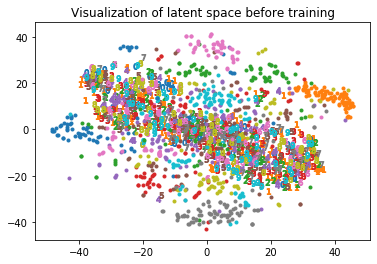

Pretrain:
*********


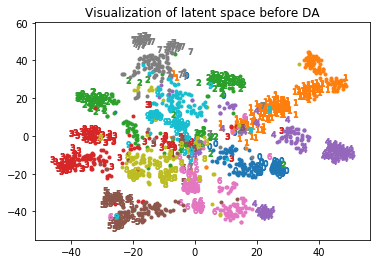

Second:
******
Test Accuracy of     0: 59% (586/980)
Test Accuracy of     1: 91% (1034/1135)
Test Accuracy of     2: 59% (610/1032)
Test Accuracy of     3: 80% (812/1010)
Test Accuracy of     4: 61% (608/982)
Test Accuracy of     5: 81% (728/892)
Test Accuracy of     6: 37% (362/958)
Test Accuracy of     7: 75% (774/1028)
Test Accuracy of     8: 49% (483/974)
Test Accuracy of     9: 46% (465/1009)

Test Accuracy (Overall): 64% (6462 /10000)
max accuracy: 0.0 iteration 0
src train 0.9688     src test 0.8438     trg 0.7500    
Test Accuracy of     0: 59% (580/980)
Test Accuracy of     1: 97% (1112/1135)
Test Accuracy of     2: 85% (879/1032)
Test Accuracy of     3: 88% (897/1010)
Test Accuracy of     4: 76% (749/982)
Test Accuracy of     5: 85% (761/892)
Test Accuracy of     6: 65% (623/958)
Test Accuracy of     7: 85% (878/1028)
Test Accuracy of     8: 66% (650/974)
Test Accuracy of     9: 67% (681/1009)

Test Accuracy (Overall): 78% (7810 /10000)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/d

max accuracy: 78.1 iteration 99
src train 0.9375     src test 0.9688     trg 0.7812    
Test Accuracy of     0: 62% (610/980)
Test Accuracy of     1: 97% (1104/1135)
Test Accuracy of     2: 89% (920/1032)
Test Accuracy of     3: 90% (914/1010)
Test Accuracy of     4: 91% (895/982)
Test Accuracy of     5: 89% (800/892)
Test Accuracy of     6: 75% (727/958)
Test Accuracy of     7: 84% (869/1028)
Test Accuracy of     8: 75% (733/974)
Test Accuracy of     9: 63% (638/1009)

Test Accuracy (Overall): 82% (8210 /10000)
max accuracy: 82.1 iteration 199
src train 0.9375     src test 0.8750     trg 0.7188    
Test Accuracy of     0: 64% (632/980)
Test Accuracy of     1: 98% (1114/1135)
Test Accuracy of     2: 92% (950/1032)
Test Accuracy of     3: 88% (897/1010)
Test Accuracy of     4: 91% (903/982)
Test Accuracy of     5: 91% (812/892)
Test Accuracy of     6: 78% (754/958)
Test Accuracy of     7: 82% (852/1028)
Test Accuracy of     8: 75% (734/974)
Test Accuracy of     9: 60% (607/1009)

Test A

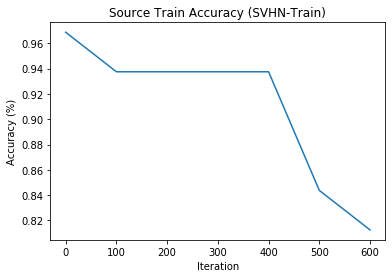

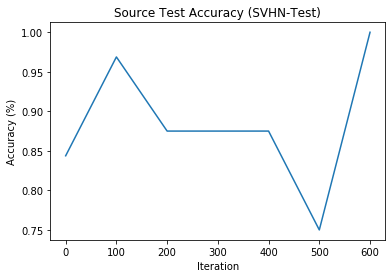

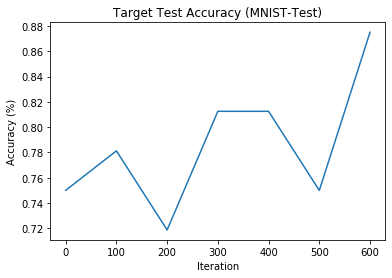

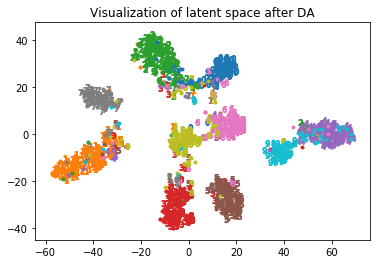

Params  {'image_size': 32, 'num_classes': 10, 'alpha_s': 0.5, 'alpha_t': 0.8, 'beta_c': 1, 'beta_sep': 1.5, 'beta_p': 4, 'train_iters': 750, 'pretrain_iters': 20000, 'batch_size': 32, 'num_workers': 2, 'lr': 0.0001, 'lr_d': 0.0001, 'beta1': 0.5, 'beta2': 0.999, 'mode': 'train', 'model_path': './models', 'mnist_path': './data/mnist', 'svhn_path': './data/svhn', 'log_pre': 1000, 'log_step': 100, 'source': 'svhn', 'target': 'mnist'}
Max_acc 83.38


In [0]:
import os
import argparse
from torch.backends import cudnn

#from data_loader import get_loader
#from solver import Solver
from termcolor import colored


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def str2bool(v):
    return v.lower() in ('true')


def main(config):
    svhn_loader, svhn_test_loader, mnist_loader, mnist_val_loader = get_loader(config)
    print("loaded")
    solver = Solver(config, svhn_loader, svhn_test_loader, mnist_loader, mnist_val_loader)
    cudnn.benchmark = True

    # create directories if not exist
    if not os.path.exists(config.model_path):
        os.makedirs(config.model_path)
    if config.mode == 'train':
        return solver.train()


if __name__ == '__main__':
    config = dotdict({
        "image_size": 32,
        "num_classes": 10,
        "alpha_s": 0.5,
        "alpha_t": 0.8,
        "beta_c": 1,
        "beta_sep": 1.5,
        "beta_p": 4,

        "train_iters": 750, #1000,
        "pretrain_iters": 20000, #20000,
        "batch_size": 32,
        "num_workers": 2,
        "lr": 0.0001,
        "lr_d": 0.0001,
        "beta1": 0.5,
        "beta2": 0.999,

        "mode": "train",
        "model_path": "./models",
        "mnist_path": "./data/mnist",
        "svhn_path": "./data/svhn",
        "log_pre": 1000,
        "log_step": 100,

        "source": "svhn",
        "target": "mnist"
    })

    print(config)
    max_acc = main(config)
    print("Params ", colored(str(config), "blue"))
    print("Max_acc", colored(str(max_acc), "blue"))
